In [1]:
%matplotlib inline
#reads cdf files in python
from spacepy import pycdf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import time
from scipy import optimize
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import read_fmt_obs as rfo

In [3]:
#Time you are interested in reconstructing
date = '2019/02/09 00:10:00'

In [4]:
reload(rfo)
#Read in Wind spectra and parameters and format them in a way that can be used by the reconstruction program
fcs,vdf_inpt = rfo.fmt_wind_spec(date)

/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


(<matplotlib.figure.Figure at 0x112b55790>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1317e1f90>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x135a44450>]], dtype=object))

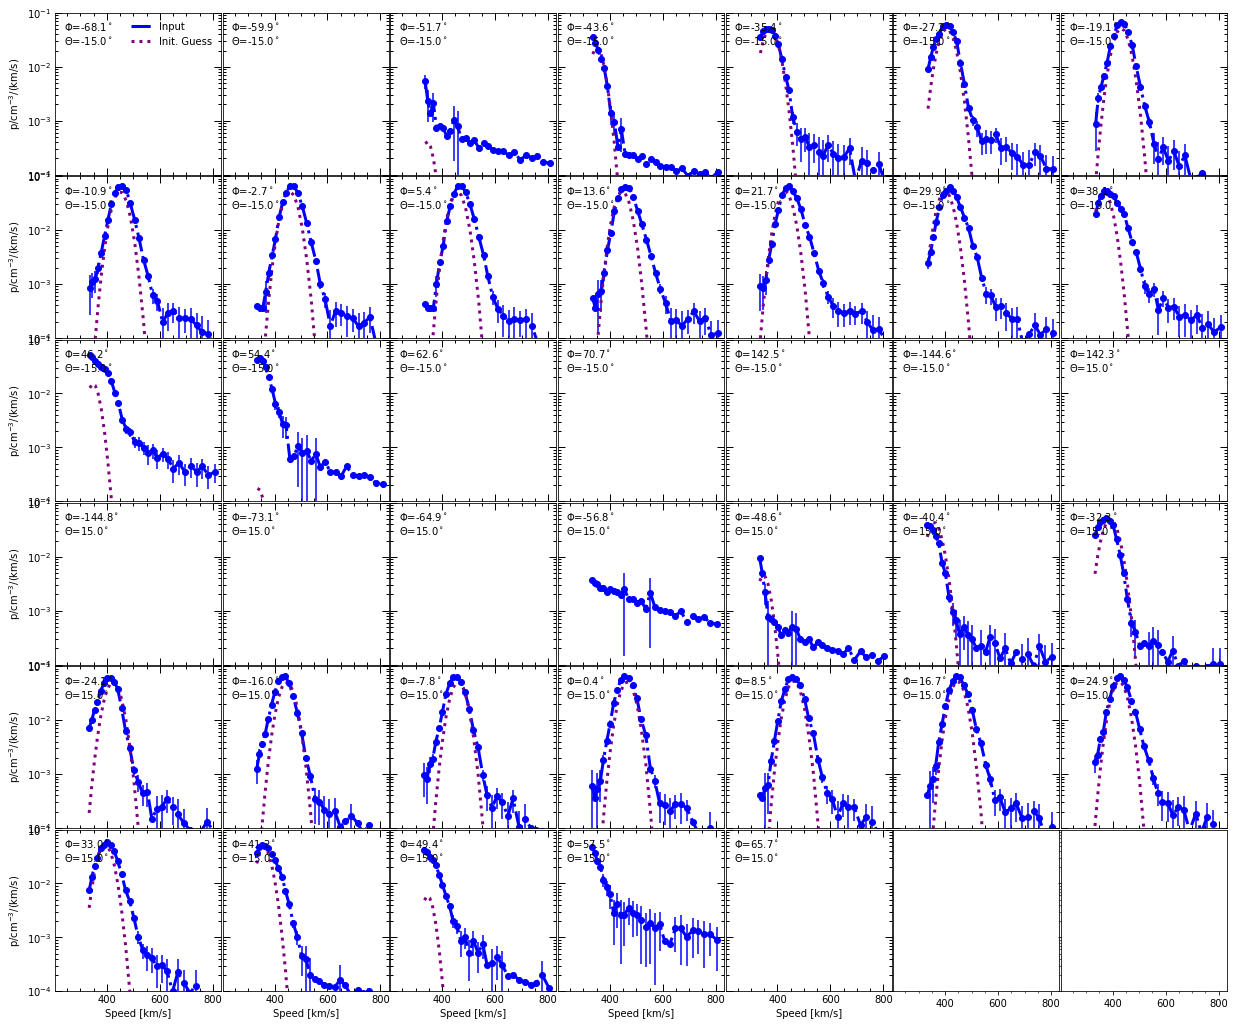

In [5]:
#Plot the Observations of all Wind FCs and the Velocity distribution if the bi-maxwellian solution 
#Derived by Wind for each FC
mff.create_fc_grid_plot(fcs,log_plot=True,ylim=[1e-4,1e-1])

In [6]:
#Trying a guess based on a previous failed try at fitting_wind_observation
human_guess = [ -4.35047381e+02,  -1.35264270e+01,   7.15811005e+00,   2.51430881e+01,
                 2.70190565e+01,   2.06592978e-02,   2.81259051e+00,   2.16901722e+00,
                 3.84810371e+01,   1.06937488e+01,   4.40914378e+01,   4.85236340e+01,
                 6.79767052e-03,   1.60664033e+00,   1.78231253e+00,]                


In [7]:
#Previous observation was at a different time so adjust velocity solution
human_guess[:3] = vdf_inpt['u_gse']

In [8]:
#Get magnetic fields from Wind CDF file that is stored in the vdf dictionary
b_gse = vdf_inpt['b_gse']
#Set the size of the VDF solution
vel_clip = 200. #km/s

(<matplotlib.figure.Figure at 0x1368a4fd0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1385539d0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x139c4eb10>]], dtype=object))

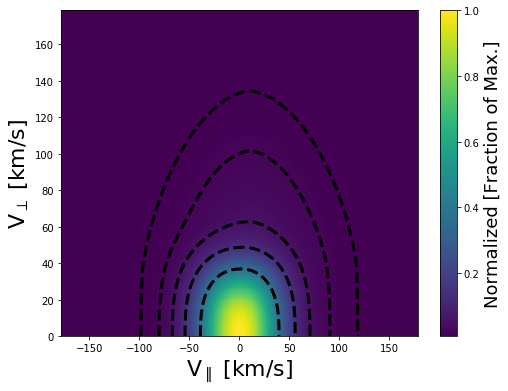

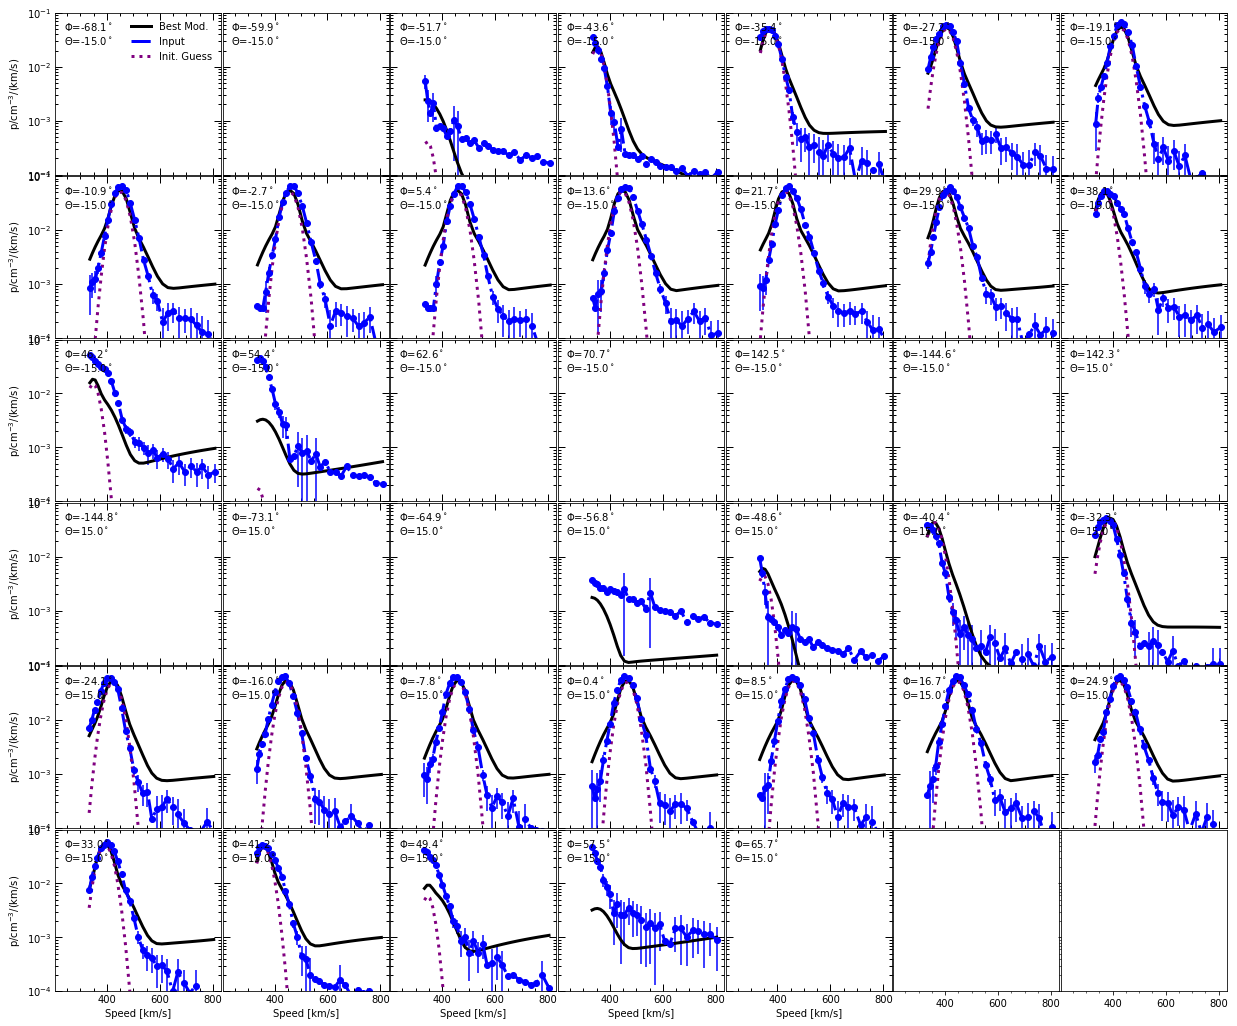

In [9]:
#Show what the initial guess assuming at generalized normal distribution
#looks like compared to the measurements and the bi-maxellian fit and Observations
dis_vdf_human = mdv.make_discrete_gennorm_vdf(human_guess,b_gse,pres=1.00,qres=1.00,clip=vel_clip,
                                                  add_ring=human_guess[8:])
#Plot what the velocity distribution looks like
mdv.plot_vdf(dis_vdf_human)
#measure the velocity distribution for each FC based on the input parameters
samp = 15.
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['dis_cur'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_human,samp)

mff.create_fc_grid_plot(fcs,log_plot=True,ylim=[1e-4,1e-1])

In [10]:
#maximum tries
max_try = 2200*3 #about 12 hours

In [11]:
#Notice NM can converge better than Powell with complex solutions, so trying it now
x1 = time.time()
#Try to minimize the sum squared errors for all FC to fit the best fit
#True means include ring in final fit
nm_human = optimize.minimize(mff.gennorm_2d_reconstruct,human_guess, args=(fcs,dis_vdf_human,True),method='Nelder-Mead',
                            options={'xtol':1e-1,'ftol':1e-1,'disp':True,'maxiter':max_try,'maxfev':max_try})
x2 = time.time()

Optimization terminated successfully.
         Current function value: 5.422494
         Iterations: 2214
         Function evaluations: 2934


In [12]:
print(nm_human.final_simplex[1])

[ 5.4224938   5.42255396  5.42256831  5.42257025  5.42257628  5.42258967
  5.4225926   5.42259575  5.42259591  5.422596    5.42260024  5.42260995
  5.42261239  5.422614    5.42261545  5.42262319]


In [13]:
nm_human.x

array([ -4.80558269e+02,  -2.90918507e+01,   1.50383918e+01,
         1.59277494e+01,   3.34159233e+01,   3.46493425e-02,
         1.19929226e+00,   1.89716818e+00,   5.42651235e+01,
         1.78139239e+01,   1.27169491e+01,   1.41868045e+01,
         2.84077617e-03,   1.00390313e+00,   7.46730392e-01])

In [14]:
chi2_bad = mff.gennorm_2d_reconstruct(nm_human.x,fcs,dis_vdf_human,add_ring=True,nproc=8,samp=samp)

In [15]:
print(chi2_bad)

5.42249379842


(<matplotlib.figure.Figure at 0x13cee7490>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13ce85ad0>)

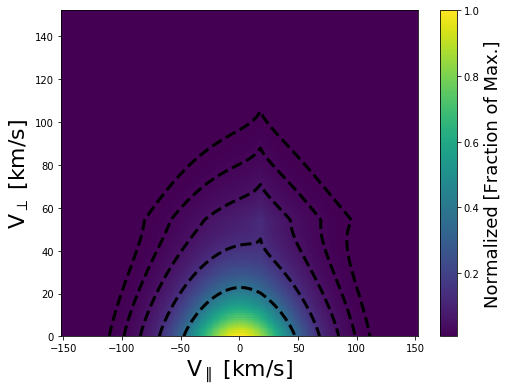

In [16]:
#Create Vper and Vpar velocity distribution and plot it
human_vdf =  mdv.make_discrete_gennorm_vdf(nm_human.x,b_gse,pres=1.00,qres=1.00,clip=vel_clip)
                                                  
#Make the observations for the best fit solution
samp = 15.
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['dis_cur'] = mdv.arb_p_response(fcs[i]['x_meas'],human_vdf,samp)
    
#Plot the best fit 2D velocity distribution
mdv.plot_vdf(human_vdf)


(<matplotlib.figure.Figure at 0x138bc7690>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ac42750>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x13e246750>]], dtype=object))

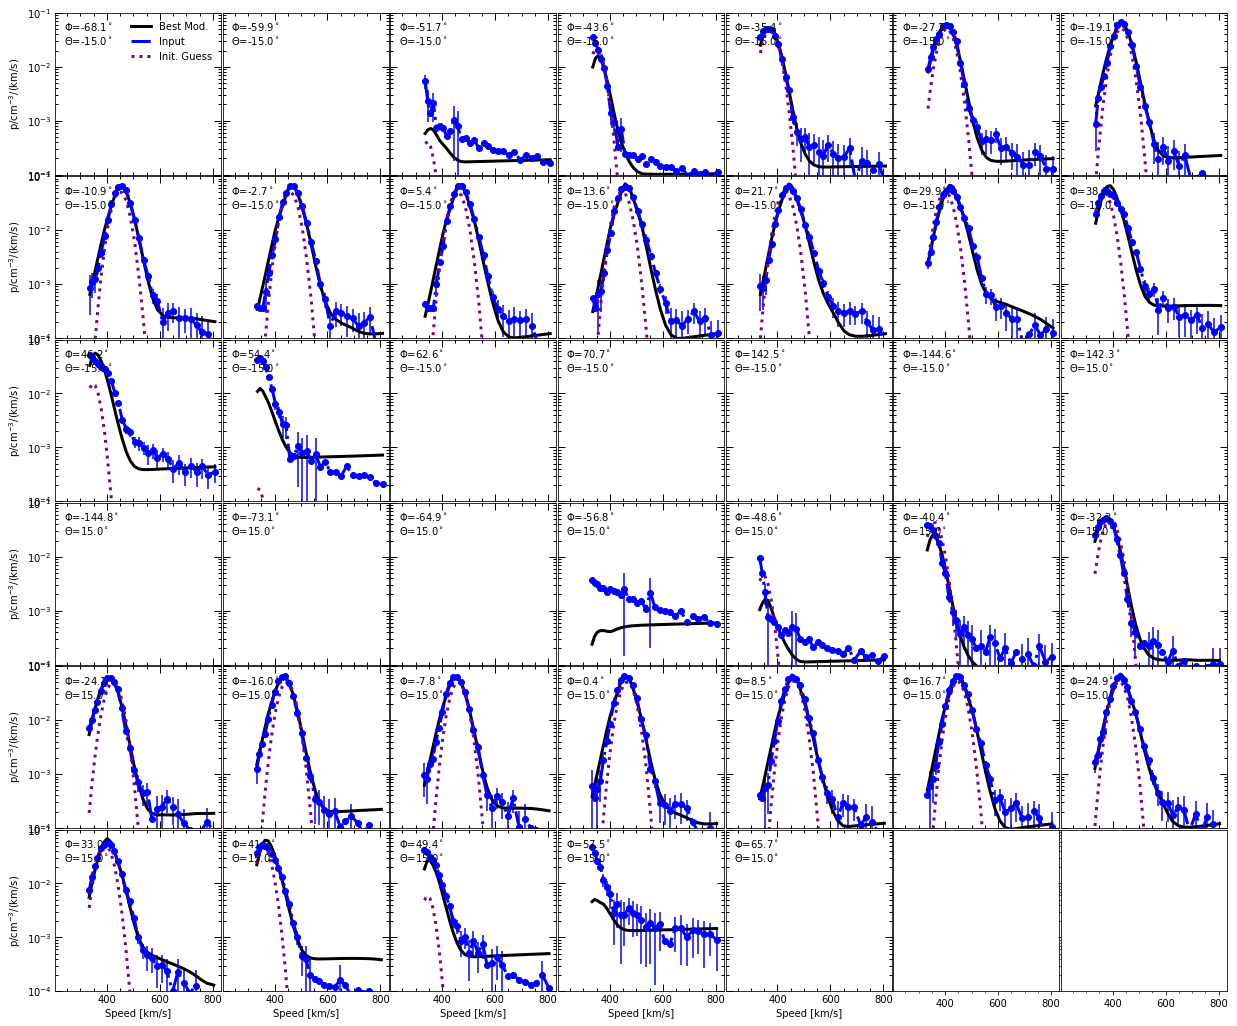

In [17]:
#Visually compare the best fit velocity solution (Best MC), the bi-maxwell (Init. Guess), and the observations (Input)
reload(mff)
mff.create_fc_grid_plot(fcs,log_plot=True,ylim=[1e-4,1e-1])

In [18]:
#Total run time until convergence
print('Total Run Time {0:7.1f} min'.format((x2-x1)/60.))

Total Run Time   375.6 min


In [23]:
fc_test = {}
fc_list = ['fc_9','fc_10','fc_30','fc_31','fc_32']
fc_list = ['fc_10','fc_32']
for j,i in enumerate(fc_list):
    fc_test['fc_{0:1d}'.format(j)] = fcs[i]
    
    

In [29]:
reload(mff)
covar,yi,yij,a0,ai,bij,Q = mff.cal_covar_nm(nm_human.final_simplex,mff.gennorm_2d_reconstruct,(fc_test,dis_vdf_human,True),return_all=True)
print(np.sqrt(np.abs(np.diag(covar))))

[ 0.05580558  0.02939802  0.03020917  0.03279756  0.03224983  0.03971429
  0.02967509  0.03373838  0.03636607  0.04006223  0.02454326  0.05008152
  0.02905525  0.02554082  0.01645072]


In [26]:
nm_human.x

array([ -4.80558269e+02,  -2.90918507e+01,   1.50383918e+01,
         1.59277494e+01,   3.34159233e+01,   3.46493425e-02,
         1.19929226e+00,   1.89716818e+00,   5.42651235e+01,
         1.78139239e+01,   1.27169491e+01,   1.41868045e+01,
         2.84077617e-03,   1.00390313e+00,   7.46730392e-01])

In [27]:
import dill
import pickle

In [28]:
#dill.dump_session('simplified_wind_spectral_fit.db',byref=True,main=False)
pickle_out = open("nm_spectral_fit_changed_input_effective_area.pickle","wb")
dill.dump(nm_human,pickle_out)
pickle_out.close()

In [30]:
#Notice NM can converge better than Powell with complex solutions, so trying it now
x1_long = time.time()
#Try to minimize the sum squared errors for all FC to fit the best fit
#True means include ring in final fit also adding lower fit tolerance to see if final solution is better
nm_human_long = optimize.minimize(mff.gennorm_2d_reconstruct,human_guess, args=(fcs,dis_vdf_human,True),method='Nelder-Mead',
                            options={'xtol':1e-2,'ftol':1e-2,'disp':True,'maxiter':max_try,'maxfev':max_try})
x2_long = time.time()

Optimization terminated successfully.
         Current function value: 5.288684
         Iterations: 4008
         Function evaluations: 5252


In [31]:
#dill.dump_session('simplified_wind_spectral_fit.db',byref=True,main=False)
pickle_out = open("nm_spectral_fit_changed_input_effective_area_long.pickle","wb")
dill.dump(nm_human_long,pickle_out)
pickle_out.close()

In [33]:
#Total run time until convergence
print('Total Run Time {0:7.1f} min'.format((x2_long-x1_long)/60.))

Total Run Time   669.4 min


In [34]:
fc_test_long = {}
fc_list = ['fc_9','fc_10','fc_30','fc_31','fc_32']
fc_list = ['fc_10','fc_32']
for j,i in enumerate(fc_list):
    fc_test_long['fc_{0:1d}'.format(j)] = fcs[i]

In [53]:
reload(mff)
covar,yi,yij,a0,ai,bij,Q = mff.cal_covar_nm(nm_human_long.final_simplex,mff.gennorm_2d_reconstruct,(fc_test_long,dis_vdf_human,True),return_all=True)


In [61]:
print(np.sqrt(2.*(5.288684)**2*np.diag(np.abs(covar))))

[  1.59368858e-02   3.92192491e-02   3.49939303e-02   3.39130228e-02
   3.25826208e-02   2.92451684e-05   1.42202460e-03   9.51139024e-03
   1.83256024e-03   3.33636746e-02   4.90392888e-02   6.83690640e-02
   1.53151766e-05   2.02805924e-03   1.61289558e-03]


In [59]:
covar_short = mff.cal_covar_nm(nm_human.final_simplex,mff.gennorm_2d_reconstruct,(fc_test,dis_vdf_human,True),return_all=False)


In [63]:
print(np.max(np.sqrt(2.*(5.288684)**2*np.diag(np.abs(covar_short)))/np.abs(nm_human.x)))

0.0391235026592


In [64]:
#Notice NM can converge better than Powell with complex solutions, so trying it now
x1 = time.time()
#Try to minimize the sum squared errors for all FC to fit the best fit
#True means include ring in final fit
nm_human_short = optimize.minimize(mff.gennorm_2d_reconstruct,human_guess, args=(fcs,dis_vdf_human,True),method='Nelder-Mead',
                            options={'xtol':5e-1,'ftol':5e-1,'disp':True,'maxiter':max_try,'maxfev':max_try})
x2 = time.time()

Optimization terminated successfully.
         Current function value: 5.670888
         Iterations: 674
         Function evaluations: 913


In [70]:
covar_short = mff.cal_covar_nm(nm_human_short.final_simplex,mff.gennorm_2d_reconstruct,(fc_test,dis_vdf_human,True),return_all=False)



In [69]:
#Total run time until convergence
print('Total Run Time {0:7.1f} min'.format((x2-x1)/60.))
#total unceratinty for each parameter as a percent
print('Percent Unc. for each parameter')
print(100.*np.sqrt(2.*(nm_human_short.final_simplex[1][0])**2*np.diag(np.abs(covar_short)))/np.abs(nm_human_short.x))

Total Run Time   118.7 min
Percent Unc. for each parameter
[  0.11726925   4.38341303  10.36181863   2.66140217   3.14403094
   2.87512074   3.71940125   5.59833353   2.33104497   1.92710781
  39.69522952   7.68885834  25.30221735   9.78901773   9.89426941]


In [87]:
covar = mff.cal_covar_nm(nm_human.final_simplex,mff.gennorm_2d_reconstruct,(fc_test,dis_vdf_human,True),return_all=False)


In [71]:
print('Percent Unc. for each parameter')
print(100.*np.sqrt(2.*(nm_human.final_simplex[1][0])**2*np.diag(np.abs(covar)))/np.abs(nm_human.x))

Percent Unc. for each parameter
[ 0.01931854  0.86215472  2.21693913  0.66579313  0.55633987  0.52998703
  1.01127704  1.32661807  0.93936466  0.55195308  2.69801755  4.01133724
  3.60696195  1.78138854  1.34935791]


In [88]:
reload(mdv)
par_unc = mdv.print_formatted_unc(nm_human.final_simplex,covar)

#parameter     Value          Uncertainty    Unit           Note                                                                            
Vx             -4.806e+02      9.284e-02     km/s           The x-component velocity of the solar wind core in GSE coordinates              
Vy             -2.909e+01      2.508e-01     km/s           The y-component velocity of the solar wind core in GSE coordinates              
Vz              1.504e+01      3.334e-01     km/s           The z-component velocity of the solar wind core in GSE coordinates              
wper            1.593e+01      1.060e-01     km/s           The width of the velocity distribution perpendicular to the magnetic field      
wpar            3.342e+01      1.859e-01     km/s           The width of the velocity distribution parallel to the magnetic field           
n               3.465e-02      1.836e-04     #/cm^3/(km/s)  The peak value of the velocity distribution in the core                         
sper         

In [ ]:
#Notice NM can converge better than Powell with complex solutions, so trying it now
x1 = time.time()
#Try to minimize the sum squared errors for all FC to fit the best fit
#True means include ring in final fit
nm_human_short = optimize.minimize(mff.gennorm_2d_reconstruct,human_guess, args=(fcs,dis_vdf_human,True),method='Nelder-Mead',
                            options={'xtol':1e0,'ftol':5e-1,'disp':True,'maxiter':max_try,'maxfev':max_try})
x2 = time.time()

In [ ]:
covar_short = mff.cal_covar_nm(nm_human_short.final_simplex,mff.gennorm_2d_reconstruct,(fc_test,dis_vdf_human,True),return_all=False)


In [ ]:
par_unc_short = mdv.print_formatted_unc(nm_human_short.final_simplex,covar_short)

In [ ]:
#Total run time until convergence
print('Total Run Time {0:7.1f} min'.format((x2-x1)/60.))